## Final Project Submission

Please fill out:
* Student name: Aaron Lee
* Student pace: self paced
* Scheduled project review date/time: #########
* Instructor name: Jeff Herman
* Blog post URL: ###########


# Background

Our client sees that all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but need help in understanding the movie industry. This project will provide a data analysis and presentation that explores what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the CEO can use when deciding what type of films they should be creating.

# TMDB database
For our research, we will be using "The Movie Database" (TMDB) API to access the the box office info we need.  TMDB has access to over half a million movies and provides detailed data about genres, budgets, revenues, and other data we will need for our project.  Below are some examples of API calls for TMDB.  

## Accessing database
Below is the code we used to access our local API keys for TMDB.  
API tokens and keys can be attained at https://www.themoviedb.org/

In [361]:
# Access TMDB
import json
import pandas as pd

def get_keys(path):
    #  retrieve your key/token from json file
    with open(path) as f:
        return json.load(f)
    
your_path = "/Users/aaronlee/.secret/tmdb_api.json"  # Make a json file that stores your key
keys = get_keys(your_path)

api_key = keys['api_key']
api_key4 = keys['api_key4']  # some searches require version 4

## TMDB database queries

### URLs for TMDB
The TMDB database can be queried as shown in the code below.  Many examples can be found online, and the developer API guide on the website is very useful.

Below is the base url for accessing TMDB.
base_url = 'https://api.themoviedb.org/3/'

You can add the following to the url for more specific searches
- /person/person_id (actors/directors info)
- /movie/movie_id (movie details)
- /keywords/[keys] (general search query)
- /discover/movie. (get movies collections)


## Sample queries
### 2017 films in order of revenue
```python
params = {'primary_release_year': 2017,
          'sort_by': 'revenue.desc'
         }
```
### Highest revenue for a Tom Cruise scifi movie
```python
params = {'with_genres': 878,
          'with_cast': 500,
          'sort_by': 'revenue.desc'
        }
```
A sample request using the params above might look like this:
```python 
response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
```
 
## Results
The response from a query contains detailed date located in ` response.json()['results']`

# Selecting our sample set

## Query the movies
First, we create an API request to get 5000 movies from the past ten years sorted by budget (2015-2019).  This will give a large cross section of recent movies which have gone into wide theater release. 

The function `movie_selection_query` is used to retrieve a list of our results.  It fetches the data by pages with 20 movies per page.

In [362]:
import requests

def movie_selection_query(n, start_year, end_year):
    """Get a list of movie data.
    Args:
        n (int): number of movies to grab.
        start_year (int): earliest production year for movies returned
        end_year (int): latest production year for movies returned
    Returns:
       list: each index is a dict representing api results for single movie.
    """
    pages = 1 + n // 20 # db returns 20 results per page
    list_of_dicts = []  # list to be returned
    print("Fetching page ", end=(""))

    for i in range(1, pages + 1):
        # each iteration and api call is for a single page (20 movies)
        params = {
                  'primary_release_year.gte': start_year,
                  #'primary_release_year.lte': end_year,
                  'sort_by': 'revenue.desc',
                  'page': i,
                  'adult': False}
        
        #Fetch Movie Data
        response = requests.get(base_url + 'discover/movie?api_key=' +  api_key, params=params)
        print(i, end=(','))
        # Go through results and add each to movie dict
        for movie in response.json()['results']:
            list_of_dicts.append(movie)
    
    print('-fetched all pages')
    return list_of_dicts[:n]

sample_size = 100 # our actual sample will be 5000 films.  This is only for demonstration
start_year = 2010
end_year = 2019
all_my_movies = movie_selection_query(sample_size, start_year, end_year)

Fetching page 1,2,3,4,5,6,-fetched all pages


## Get all the movie id numbers from the query
The previous code retrieved the basic info for each movie.  This includes the movie 'id' number which will help us fetch the detailed info for each movie.  

Below, we extract all the movie 'id's from the previous query.  

In [363]:
all_my_movies[0]  # look at data for first movie (it seems to be an erroroneous response)

# lets grab all of the movie numbers
movie_ids = [movie['id'] for movie in all_my_movies]

movie_ids.pop(0)  #  The first item from the query is popped from the list.  Leaving it in causes error.

299534

## Make API call for each movie to grab detailed info
Now that we can the movie 'id' for TMDB, we can do a detailed movie api call for all of the selected movies.  This data includes: title, revenue, budget, runtime, etc.  

In [364]:
import os

def fetch_all_movies(movie_ids, path):
    """
    Fetches each individual movie details with query from TMDB
    Writes the results to csv for later use.
    Args:
        movie_ids (list):  all movie ids for our data project
        path (string): where we want our file to be stored
    Returns:
       
    """
    all_movie_details = []
    i = 1
    print("Fetching movies")
    for movie in movie_ids:
        #Fetch Movie Data
        #print(movie, end=',')
        #print('', end='.')
        movie_response = requests.get(base_url + 'movie/' + str(movie) + '?api_key=' +  api_key)
        #print(movie_response)
        all_movie_details.append(movie_response.json())
        i += 1
    print("--end of queries.")
    df = pd.DataFrame(all_movie_details)

    output_file = os.path.join(path,'tmdb-movies.csv')

    f = df.to_csv(output_file, index=False)
    return all_movie_details, f



path = "/Users/aaronlee/flatiron-ds-course/module01/final_project"
load_from_file = True


if load_from_file:
    # if the query is valid for project, all data will be stored in file tmdb-movies.csv
    df = pd.read_csv('tmdb-movies.csv')
else:
    # we need to do query and write it to file
    all_movie_details, f = fetch_all_movies(movie_ids, path)
    df = pd.DataFrame(all_movie_details)
    output_file = os.path.join(path,'tmdb-movies.csv')
    df.to_csv(output_file, index=False)
    all_movie_details = fetch_all_movies(movie_ids, path) 
    # After running the query, change load_from_file to True


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 27 columns):
adult                    4990 non-null object
backdrop_path            4570 non-null object
belongs_to_collection    1470 non-null object
budget                   4990 non-null float64
genres                   4990 non-null object
homepage                 1961 non-null object
id                       4990 non-null float64
imdb_id                  4974 non-null object
original_language        4990 non-null object
original_title           4990 non-null object
overview                 4981 non-null object
popularity               4990 non-null float64
poster_path              4960 non-null object
production_companies     4990 non-null object
production_countries     4990 non-null object
release_date             4981 non-null object
revenue                  4990 non-null float64
runtime                  4987 non-null float64
spoken_languages         4990 non-null object
status        

# Clean the data
With detailed info on every movie in our search now stored in a Pandas DataFrame, we will now clean our data for further exploration.  



## Remove missing or incomplete data 
We chose to eliminate movies in the data set that do not contain fully updated with data we will be studying.  TMDB movie data is pretty thorough, and less than 1 percent of the movies are lacking necessary info.  

Row entries with null values in the columns (id, 'runtime', 'release_date', 'imdb_id') were dropped from the set.

Unnecessary columns were eliminated for convenience ('adult', 'backdrop_path', 'homepage', 'video', 'status_code', 'status_message', 'status', 'tagline', 'poster_path', 'overview')

No NaN values remain in the set after these lines and columns are dropped.  

We also convert the 'release_date' column to datetime objects so we can work with them numerically and compare them.

In [365]:
# df.isna().sum()  # found some without id, runtime, release_date.

df.dropna(subset=['id', 'runtime', 'release_date', 'imdb_id'], inplace=True)  # Eliminates 28 entries

# We choose to drop the columns that are not necessary for our study. 
df_clean = df.drop(['adult', 'backdrop_path', 'homepage', 'video', 'status_code', 'status_message', 
                    'status', 'tagline', 'poster_path', 'overview'], axis=1)

# convert dates to datetime objects for comparison
datetimes = pd.to_datetime(df["release_date"])
df_clean['release_date'] = datetimes

df_clean.isna().sum()  
df_clean.info()  # this results in no NaN values, and a loss of only 28 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4972 entries, 0 to 4998
Data columns (total 17 columns):
belongs_to_collection    1470 non-null object
budget                   4972 non-null float64
genres                   4972 non-null object
id                       4972 non-null float64
imdb_id                  4972 non-null object
original_language        4972 non-null object
original_title           4972 non-null object
popularity               4972 non-null float64
production_companies     4972 non-null object
production_countries     4972 non-null object
release_date             4972 non-null datetime64[ns]
revenue                  4972 non-null float64
runtime                  4972 non-null float64
spoken_languages         4972 non-null object
title                    4972 non-null object
vote_average             4972 non-null float64
vote_count               4972 non-null float64
dtypes: datetime64[ns](1), float64(7), object(9)
memory usage: 699.2+ KB


## Selection criteria
We will attempt to look at major trends in movies for a new production company, so we will check the data as it relates primarily to budget and revenue.  We will attempt to inform the company what types of movies will be profitable going forward, and potential ways to maximize profits in the current film industry.

Selection criteria
- Movies with runtimes over one hour. Eliminate shorts and bonus material videos.
- Movies with a budgets over \$500,000.  Eliminates most documentaries and smaller indie films.  
- Movies with revenue over \$500,000.  Ensures a wide theatrical release.

## Date ranges
For this study we chose to study the last 5 years of movies for contemporary trends, and the last 10 years to study longer industry trends.  The 'release_date' column is a datetime object.  We will use the date to sort out the last 10 and 5 years into two different DataFrames for exploration.  We will not include data from 2020 due to COVID-19 disruption of the movie industry, but the impact of the pandemic should be considered prior to entering movie production.

After this filter is applied, we have around 750 and 1500 movies for our 5 and 10 year data sets respectively.

In [366]:
# Filtering data using noted criteria
release_year = df_clean['release_date'].map(lambda x: x.year)
release_month = df_clean['release_date'].map(lambda x: x.month)

df_clean['release_year'] = release_year
df_clean['release_month'] = release_month


# 10 years of movies
df10 = df_clean[(df_clean['revenue'] > 5e5) 
        & (df_clean['budget'] > 5e5)
        & (df_clean['release_year'] >= 2010)
        & (df_clean['release_year'] < 2020)
       ]  # get rid of shorts and non voted

# 5 years of movies
df5 = df_clean[(df_clean['runtime'] > 60) 
        & (df_clean['revenue'] > 5e5) 
        & (df_clean['budget'] > 5e5)
        & (df_clean['release_year'] >= 2015)
        & (df_clean['release_year'] < 2020)
       ]  # get rid of shorts and non voted


df5.isna().sum()  # all the data will work for our purposes.  We might later drop some cols to simplify

belongs_to_collection    500
budget                     0
genres                     0
id                         0
imdb_id                    0
original_language          0
original_title             0
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    0
spoken_languages           0
title                      0
vote_average               0
vote_count                 0
release_year               0
release_month              0
dtype: int64

# Budget and Revenue 
Our investigation will be focused on the budget and revenues of movies.
We begin by exploring these for our set of movies. by looking at the centerl tendencies.

In [367]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Budget and Revenue (past 5 years)\n")

print("Budget Centeral Tendency")
print('Min Budget: {:.2f} Million'.format(df5['budget'].min() / 1e6))
print('Max Budget: {:.2f} Million'.format(df5['budget'].max() / 1e6))
print('Mean Budget: {:.2f} Million'.format(df5['budget'].mean() / 1e6))
print('Median Budget: {:.2f} Million'.format(df5['budget'].median() / 1e6))
print('First Quartile (25%): {:.2f} Million'.format(df5['budget'].quantile(0.25) / 1e6))
print("IQR (25-50%): {:.2f} Million".format((df5['budget'].quantile(0.75) - df5['budget'].quantile(0.25)) / 1e6))
print('Third Quartile (75%): {:.2f} Million'.format(df5['budget'].quantile(0.75) / 1e6))
print("Std Dev: {:.2f} Million".format(df5['budget'].std() / 1e6))

print("\nRevenue Central Tendency")
print('Min Revenue: {:.2f} Million'.format(df5['revenue'].min() / 1e6))
print('Max Revenue: {:.2f} Million'.format(df5['revenue'].max() / 1e6))
print('Mean Revenue: {:.2f} Million'.format(df5['revenue'].mean() / 1e6))
print('Median Revenue: {:.2f} Million'.format(df5['revenue'].median() / 1e6))
print('First Quartile (25%): {:.2f} Million'.format(df5['revenue'].quantile(0.25) / 1e6))
print("IQR (25-50%): {:.2f} Million".format((df5['revenue'].quantile(0.75) - df['revenue'].quantile(0.25)) / 1e6))
print('Third Quartile (75%): {:.2f} Million'.format(df['revenue'].quantile(0.75) / 1e6))
print("Std Dev: {:.2f} Million".format(df['revenue'].std() / 1e6))


# df.info()
# df.describe()
# df['budget'].describe()
# df['revenue'].describe()

Budget and Revenue (past 5 years)

Budget Centeral Tendency
Min Budget: 0.70 Million
Max Budget: 300.00 Million
Mean Budget: 52.21 Million
Median Budget: 30.00 Million
First Quartile (25%): 12.00 Million
IQR (25-50%): 57.00 Million
Third Quartile (75%): 69.00 Million
Std Dev: 56.85 Million

Revenue Central Tendency
Min Revenue: 11.82 Million
Max Revenue: 2068.22 Million
Mean Revenue: 193.34 Million
Median Revenue: 80.25 Million
First Quartile (25%): 34.49 Million
IQR (25-50%): 185.60 Million
Third Quartile (75%): 128.01 Million
Std Dev: 185.39 Million


Promotional and other costs are not considered as part of this study, so the true results are incomplete.  However, mean revenues are more than five times the mean budget.  Movies with budgets in the Third Quartile (90M USD) are still smaller than revenues in the First Quartile (109M USD).  This is further illustrated by the box plots below.

*Hollywood Reporter* https://www.hollywoodreporter.com/news/200-million-rising-hollywood-struggles-721818reporter article shows that worldwide promotion for large theatrical releases is currently in the 150 to 200 million dollar range.

[Text(0.5, 0, 'Millions (USD)')]

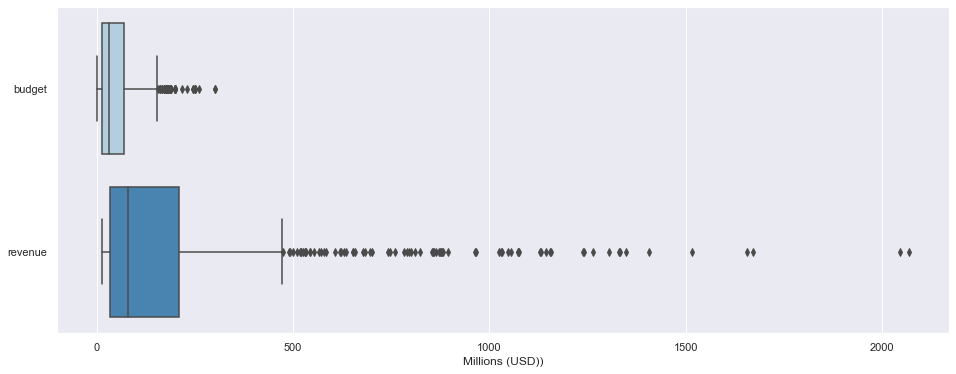

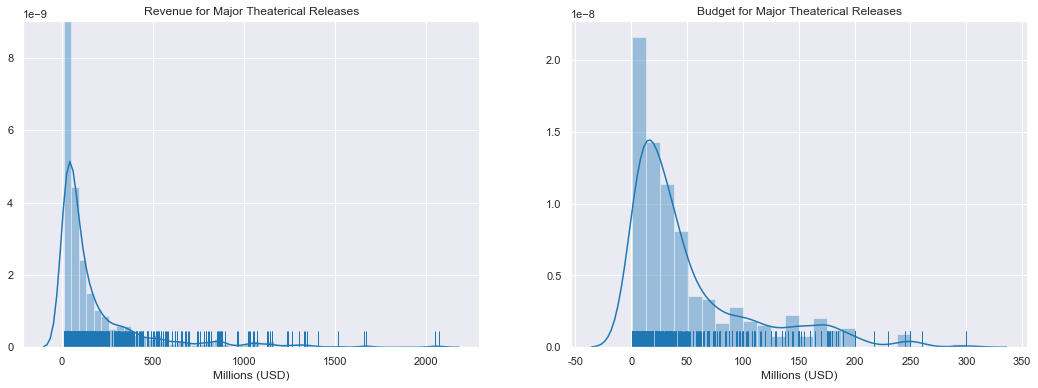

In [368]:
# df with just revenue and budget
df_money = df5[['budget', 'revenue']].copy()

sns.set_style('darkgrid')
dims = (6, 18)

# df with just revenue and budget
df_money = df5[['budget', 'revenue']].copy()

sns.set_style('darkgrid')
sns.set_context("notebook")

dims = (22, 6)
#sns.boxplot(data=df_returns, palette='Reds')
# xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
# ax.set_title("Revenue for Major Theaterical Releases")
# ax.set_xticklabels(xlabels)
# ax.set(xlabel='Millions (USD)')

plt.figure(figsize=(16, 6))

ax = sns.boxplot(data=df_money, palette='Blues', orient='h')
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel="Millions (USD))")


# Distribution  Plot
dims = (18, 6)
fig, ax2 = plt.subplots(1, 2, figsize=dims)

# Revenue histo plot
sns.distplot(df5['revenue'], ax=ax2[0], rug=True) 
ax2[0].set_title("Revenue for Major Theaterical Releases")
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax2[0].get_xticks()]
ax2[0].set_xticklabels(xlabels)
ax2[0].set(xlabel='Millions (USD)')


# Budget regression plot
sns.distplot(df5['budget'], ax=ax2[1], rug=True) 
ax2[1].set_title("Budget for Major Theaterical Releases")
xlabels = ['{:d}'.format(int(x/1000000)) for x in ax2[1].get_xticks()]
ax2[1].set_xticklabels(xlabels)
ax2[1].set(xlabel='Millions (USD)')

# Spacing between if we put them on top of each other to share axis
# ax[1].set_xlim([0, 3000000000])
# ax[0].set_xlim([0, 3000000000])
# plt.tight_layout()
# plt.subplots_adjust(top=0.8)


Both budget and revenue are left skewed, and returns tend to be significantly higher than budgets, with revenue outliers on the high side being far more prevalent than budget outliers.  Being able to identify the characteristics of the high revenue outliers would be useful for the

# What variables affect revenue?
Now we will attempt to find correlations between movie attributes and the revenue data.
Specifically, our client wants to know what kind of movie they should be making for the current market.  We must look at genre, sequels, release_date, etc.

Text(0.5, 1, 'Pearson Coefficients')

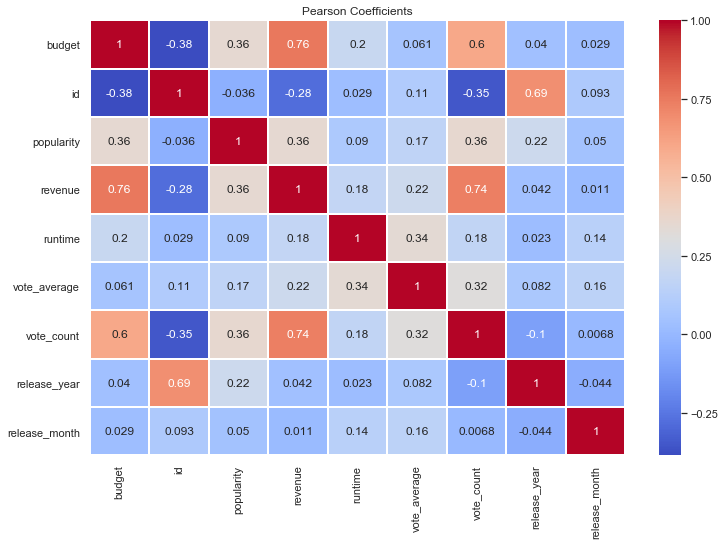

In [369]:
import numpy as np

pearsoncorr = df5.corr(method='pearson') 
plt.figure(figsize=(12,8))

# make a heatmap out of correlation df 
ax = sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            annot=True,
            linewidth=1)

#df.columns
ax.set_ylim(9.0, 0)  # not needed with old Matplotlib version.  
ax.set_title('Pearson Coefficients')


The coefficients above that stick out as having high positive corelations are **budget** and **revenue**.  of course user_votes is also linked closely to revenue (people vote on movies they see).  

From the above heatmap, we should look at the following numerical data:
- budget: high degree of correlation with revenue
- runtime: low degree correlation with revenue

There may also be correlation with other some categorical information about the movie such as:
- is the movie a sequel or part of a franchise?
- what is the genre of the movie?
- what month or date was the release?

# Relationship between a movie's budget and revenue
The numerical category with the highest correlation is user votes for the movie.  Making quality movies that are liked by audiences is likely the best way to guarantee high returns.  Additionally, the budget seems to have a high degree of correlation with revenue, and we will look at that relationship now. 

After looking at how correlation varied by budget, we decided to use a 2nd order curve to fit the scatterplot of revenue vs budget.  Especially on the high end, the more you spend, the more you make.

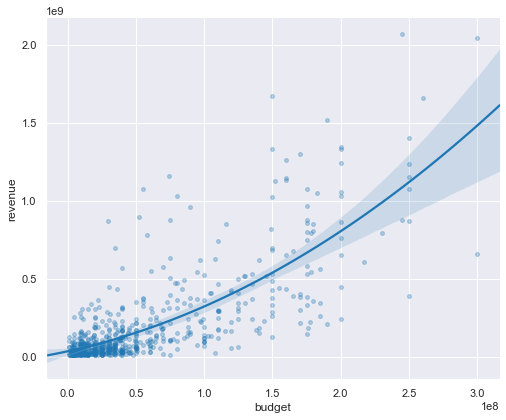

In [434]:
# calculate pearson corr for budget revenue
pval = df5[['budget', 'revenue']].corr(method ='pearson').iloc[0,1]

# make regression plot
fgrid = sns.lmplot(data=df5, x='budget', y='revenue', height=6, aspect=1.2, 
                   scatter_kws={"s":15,'alpha':0.3},
                   order=2
                  )

# annotate with pval
ax = fgrid.axes[0,0] 
#ax.set_title('Pearson Corr: {:.2f}'.format(pval))
ax.set_alpha(0.5)


# How has this relationship changed over time?

0.7857885251148837
0.7338286406507307
0.7854824932738818
0.7384312269263392
0.8660047504435704
0.7586509822159415
0.7722372093245515
0.7527724518951926
0.7926475055375759
0.7529449819597749


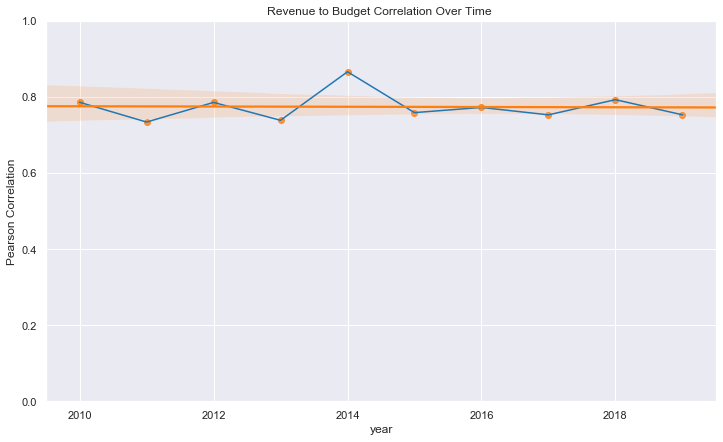

In [371]:

# make a new year col
df_date = df10.copy()

df_date['release_year'] = pd.DatetimeIndex(df_date['release_date']).year

corrs = [] 

start_year = 2010
end_year = 2019
for year in range(start_year, end_year + 1):
    rev = df_date[df_date['release_year'] == year]['revenue']
    bud = df_date[df_date['release_year'] == year]['budget']
    c = rev.corr(bud, method='pearson')
    print(c)
    corrs.append({'year': int(year), 'Pearson Correlation': c})

corrs

df_corrs = pd.DataFrame(corrs)

plt.figure(figsize=(12,7))
ax = sns.lineplot(data=df_corrs, x='year', y='Pearson Correlation')
ax.set_ylim(0,1)
ax.set_title("Revenue to Budget Correlation Over Time ")
sns.regplot(data=df_corrs, x='year', y='Pearson Correlation')



The releationship between budget and revenue seems to hold relatively constant over the past 10 years, so this can be considered to be a very stable correlelation for movie success.

## Return on Investment for big budget films

Perhaps big budget films have a different correlation between budget and revenue than films at large.  If we find that high end big budget films are disproportionaly successful, then our client should follow suit and outspend to get big returns.  

We will look at films that are in the top quartile for budgets and compare them to the rest of the field.

Text(0.5, 1.0, 'Films above median budget')

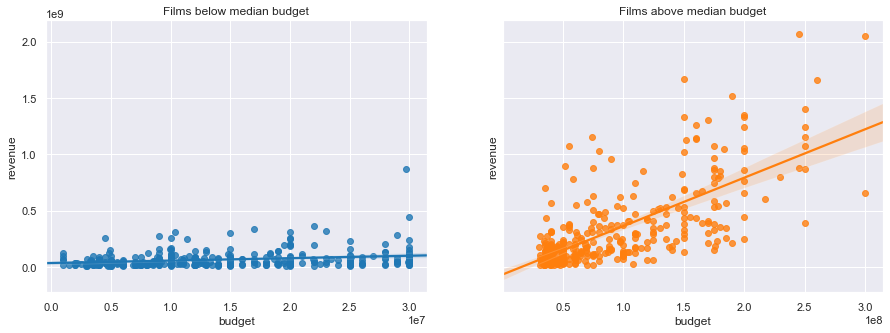

In [372]:
# look at plots of revenue and budget, but split up by the quantile/quartile of budget 

def lmplot_by_budget(df, low, high, ax):
    """
    Make a plot of revenue vs budget, but specify the range of budgets using low and high quantile
    Plot will show all movies between the low and high quantile
    Args:
        df (Pandas.DataFrame):  cleaned df of movies from TMDB per previous functions
        low (float): low budget quantile
        high (float): high budget quantile
    Returns:
    """
    dfq = df[(df['budget'] > df['budget'].quantile(low)) & (df['budget'] <= df['budget'].quantile(high))]  
    pval = dfq[['budget', 'revenue']].corr(method ='pearson').iloc[0,1]

    # make regression plot for top quartile
    sns.regplot(data=dfq, x='budget', y='revenue', ax=ax)
    

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5), sharey=True)

# this was originally set up to do plots of quartiles, but it reduced the reliability of the data by doing so.
for i in range(2):
    lmplot_by_budget(df5, 0.5 * i, 0.5 * (i + 1), ax[i])
    

ax[0].set_title('Films below median budget') 
ax[1].set_title('Films above median budget') 
# perhaps 2nd order equation?

# Do movie franchises fare significantly better than standalone films?

The database used for this study only shows if the film was part of a franchise, meaning that even the first film in a series would be categorized as any other franchise movie.  Since we generally expect that only successful movies are given sequels, this will greatly skew the result.  A closer look at true sequels might be a subject for further study.

Pearson Correlations:
	Franchise: 0.77
	No Franchise: 0.66

29.78% of movies in past five years are part of a franchise.


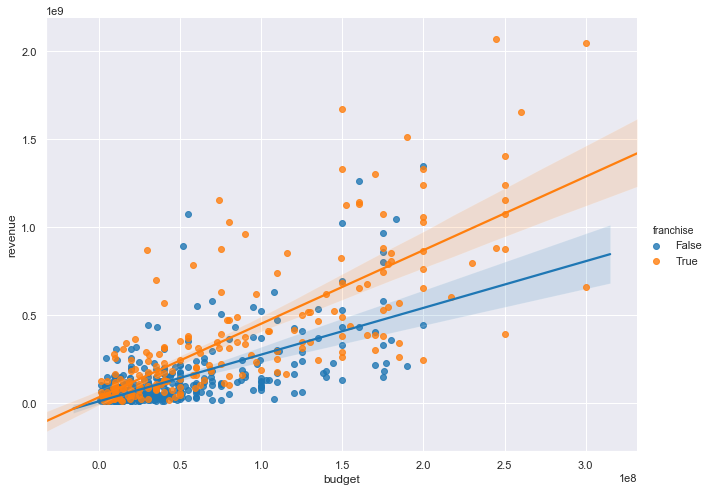

In [439]:
from scipy import stats

#print(df5['belongs_to_collection'].isna())
df5.loc[:, ['franchise']] = df['belongs_to_collection'].notna()

#slope, intercept, r_value, p_value, std_err = stats.linregress(df5['budget'],df5['revenue'])
#print("Slope:", slope)

ax = sns.lmplot(x="budget", 
                y="revenue", 
                hue="franchise", 
                data=df5, 
                height=7, 
                aspect=1.3,
              )  

# add Pearson
pval_yes = df5.loc[df5['franchise']==True, ['budget', 'revenue']].corr(method ='pearson').iloc[0,1]
pval_no = df5.loc[df5['franchise']==False, ['budget', 'revenue']].corr(method ='pearson').iloc[0,1]
print("Pearson Correlations:\n\tFranchise: {:.2f}\n\tNo Franchise: {:.2f}".format(pval_yes, pval_no))

# percentage of movies that are franchises
print()
print("{:.2%} of movies in past five years are part of a franchise.".format(df5['franchise'].sum() / len(df5)))


# df_sequels = df5.loc[:, ['franchise', 'revenue']]

# plt.figure(figsize=(16,3))
# ax = sns.boxplot(data=df_sequels, x='revenue', y='franchise', orient='h')

# xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
# ax.set_xticklabels(xlabels)
# ax.set(xlabel="Millions (USD))")


# What about genres?

TMDB provides a dictionary of all genres provided for a movie (up to 3).  This makes it difficult to categorize a movie by a single genre.  A "RomCom" might best be described by both categories, but the database only has categores of Romance and Comedy separate.  The first category is the primary category for the movie and will be used for the following analysis.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3976 entries, 0 to 0
Data columns (total 4 columns):
genre           3976 non-null object
revenue         3976 non-null float64
release_date    3976 non-null datetime64[ns]
budget          3976 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 155.3+ KB


Text(0.5, 1.0, 'Mean Revenue and Budget by Genre')

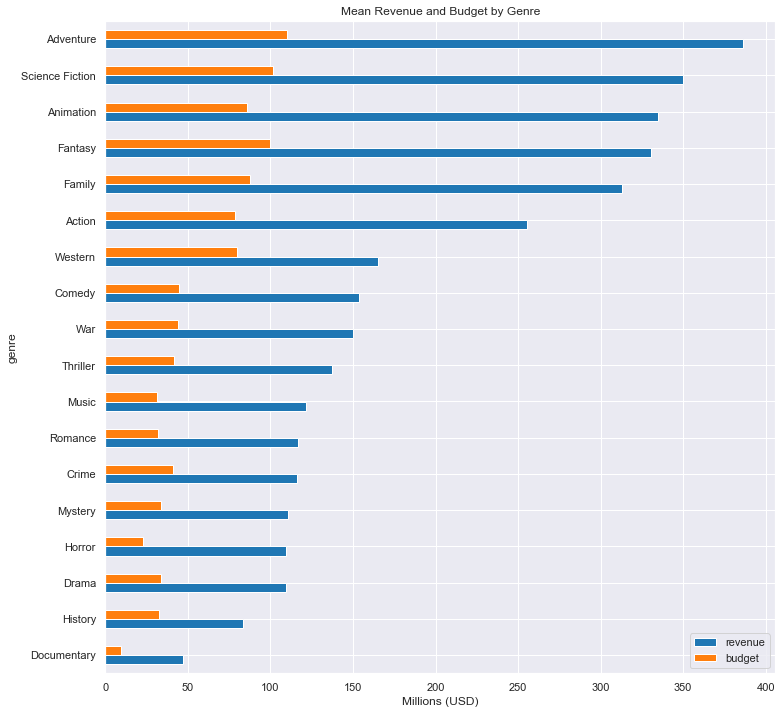

In [440]:
df_genres = df10.copy()
df_genres = df_genres.loc[:, ['genres', 'revenue', 'release_date', 'budget']]


# my dictionaries read in as strings for my genre!!!
# lets convert them back
df_genres['genres'] = df_genres['genres'].map(lambda x: eval(x))


# # make df that has separate entry for each genre.  A movie with three genres would effect three categories.
# expanded df
df_gen_exp = pd.DataFrame({'genre':[], 'revenue':[], 'release_date':[], 'budget':[]})


for col, row in df_genres.iterrows():
    try:
        for genres in row['genres']:
            new = pd.DataFrame({'genre':[genres['name']], 'revenue':[row['revenue']], 'release_date':[row['release_date']], 'budget':[row['budget']] })
            df_gen_exp = pd.concat([df_gen_exp, new])
    except Exception as e:
        print(e)

        
df_gen_exp.info()
    
df_genres_grouped = df_gen_exp.groupby(['genre']).mean().sort_values('revenue')
# df_genres_grouped = df_genres_grouped[['revenue', 'budget']]
df_gen_exp.reset_index()

df_genres_grouped
                                 
ax = df_genres_grouped.plot.barh(figsize=(12,12))

xlabels = ['{:d}'.format(int(x/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.set(xlabel='Millions (USD)')
ax.set_title("Mean Revenue and Budget by Genre")


In [441]:

df_gen_exp['release_year'] = pd.DatetimeIndex(df_gen_exp['release_date']).year
df_genres_by_year = df_gen_exp.copy()
df_genres_by_year


df_plot = df_genres_by_year.groupby(['release_year', 'genre']).mean().unstack()
df_plot.head()


revenue                                            \
genre               Action     Adventure     Animation        Comedy   
release_year                                                           
2010          1.604780e+08  2.832963e+08  3.896976e+08  1.271614e+08   
2011          1.866155e+08  3.340435e+08  2.960908e+08  1.325578e+08   
2012          2.574271e+08  4.462577e+08  3.287246e+08  1.511102e+08   
2013          2.281996e+08  3.321033e+08  2.925334e+08  1.314442e+08   
2014          3.012014e+08  4.057142e+08  2.886556e+08  1.488812e+08   

                                                                     \
genre                Crime  Documentary         Drama        Family   
release_year                                                          
2010          8.176359e+07  117224271.0  9.899663e+07  3.005650e+08   
2011          1.458414e+08   43910006.0  8.096138e+07  2.086386e+08   
2012          1.337308e+08   33063478.0  1.477405e+08  2.821551e+08   
2013          1.214427e+08          NaN  8.668054e+07  3.480158e+08   
2014          8.999697e+07          NaN  1.103695e+08  2.621811e+08   

                                          ...        budget                \
genre              Fantasy       History  ...       Fantasy       History   
release_year                              ...                               
2010          2.975767e+08  8.077690e+07  ...  1.007391e+08  1.630040e+07   
2011          3.329451e+08  6.471154e+07  ...  9.138333e+07  3.416667e+07   
2012          3.849121e+08  2.250723e+08  ...  1.092347e+08  5.600000e+07   
2013          3.018637e+08  6.569294e+07  ...  1.184368e+08  1.843273e+07   
2014          3.195739e+08  1.053406e+08  ...  9.922385e+07  3.777914e+07   

                                                                      \
genre               Horror         Music       Mystery       Romance   
release_year                                                           
2010          2.030714e+07  4.269328e+07  3.769136e+07  4.158209e+07   
2011          2.908333e+07  2.948667e+07  4.973333e+07  3.327519e+07   
2012          2.573077e+07  2.656532e+07  3.502857e+07  2.884348e+07   
2013          3.216667e+07  1.400000e+07  5.337500e+07  2.508405e+07   
2014          1.640000e+07  3.957500e+07  4.455556e+07  3.389439e+07   

                                                                       
genre        Science Fiction      Thriller           War      Western  
release_year                                                           
2010            8.585455e+07  4.410846e+07  3.308000e+07   38000000.0  
2011            7.493333e+07  4.699574e+07  8.000000e+07  149000000.0  
2012            1.080000e+08  4.715122e+07  4.500000e+07   63000000.0  
2013            9.980455e+07  4.753375e+07  3.333333e+07  255000000.0  
2014            1.051799e+08  3.999143e+07  5.420000e+07   25250000.0  

[5 rows x 36 columns]

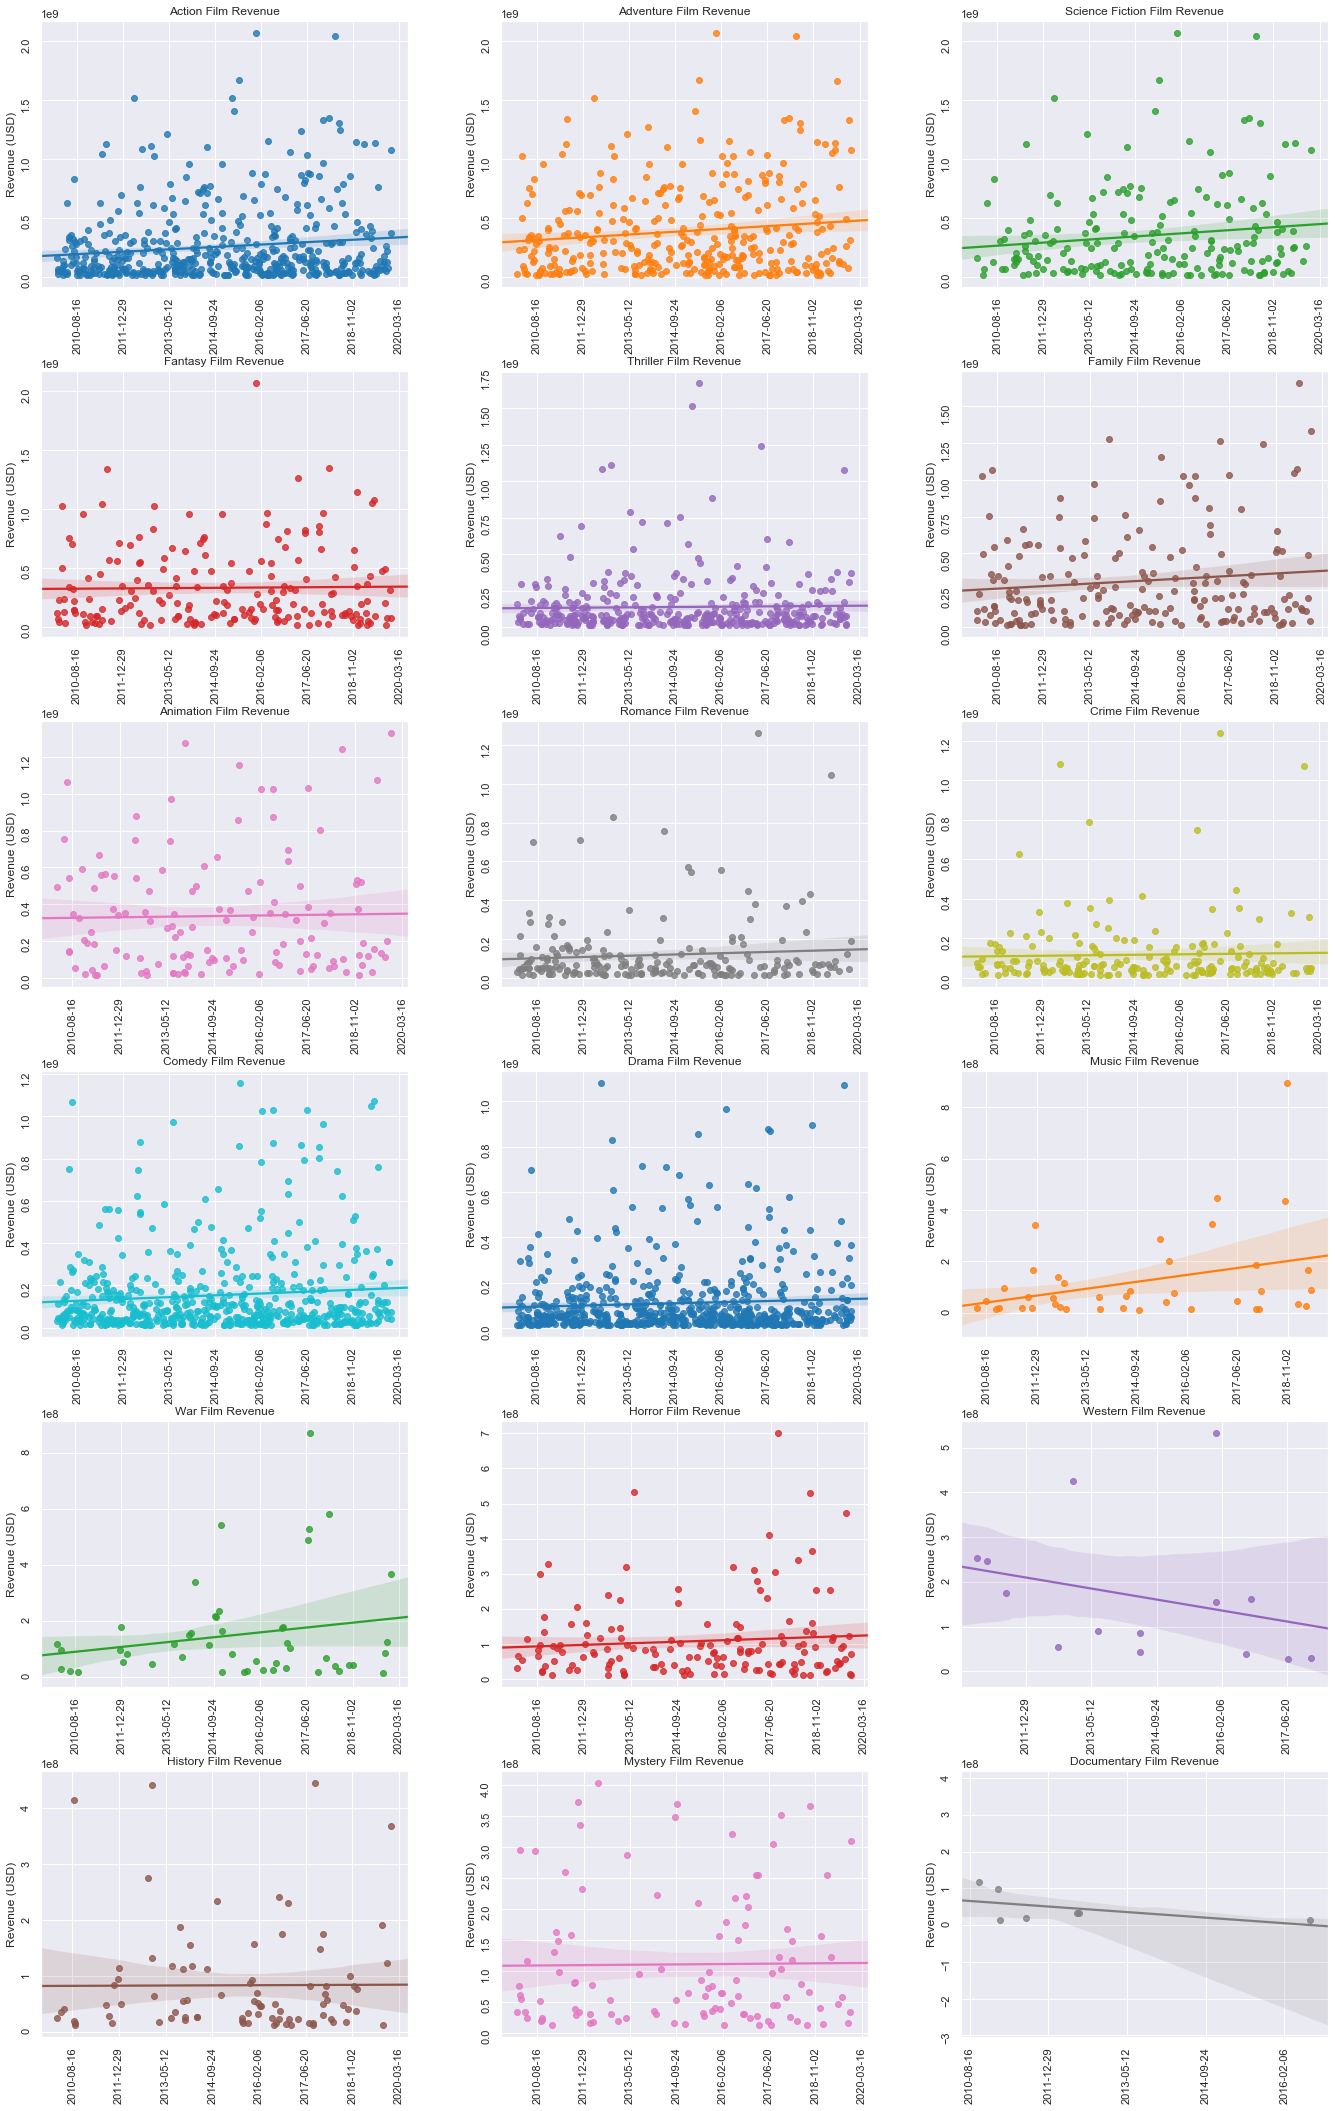

In [442]:
from datetime import datetime
from matplotlib import dates

# make a simple list of the genre names for the loop
genre_list = list(df_gen_exp['genre'].unique())
genre_list

#datetime.strptime('2000-04-01', %Y-%m-%d)
df_gen_exp2 = df_gen_exp.copy()

df_gen_exp2['date'] =  df_gen_exp2['release_date'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d')) 
df_gen_exp2['datenum'] = df_gen_exp2['date'].apply(lambda x: dates.datestr2num(x))
# df_gen_exp
# df_gen_exp.info()


fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(20,30))
fig.tight_layout(pad=5)
sns.set_style('darkgrid')


for i, ax in zip(range(len(genre_list)), axes.flat):
    df1 = df_gen_exp2.loc[df_gen_exp2['genre'] == genre_list[i]]
    sns.regplot(x='datenum', y='revenue', data=df1, ax=ax)
    xlabels = ['{}'.format(datetime.strftime(dates.num2date(x), '%Y-%m-%d')) for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    ax.tick_params(labelrotation=90)
    ax.set(title="{} Film Revenue".format(genre_list[i]), xlabel="", ylabel='Revenue (USD)')
    #ax.set_ylim(0, 800000000)






140000000.0 380000000.0
700000.0 140000000.0
0       2.545455
1       6.181818
2      10.666667
3      14.700000
4      19.428571
         ...    
115    32.875000
116    37.428571
117    41.916667
118    46.000000
119    51.000000
Name: release_week, Length: 120, dtype: float64


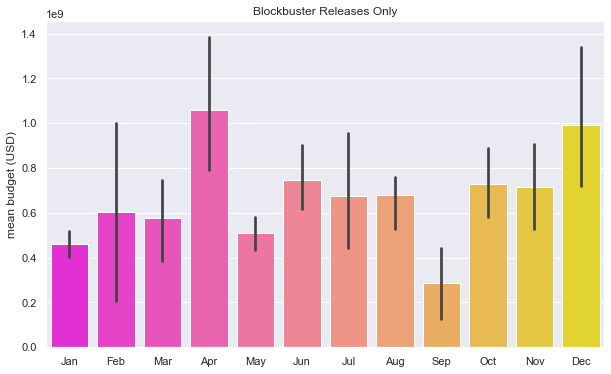

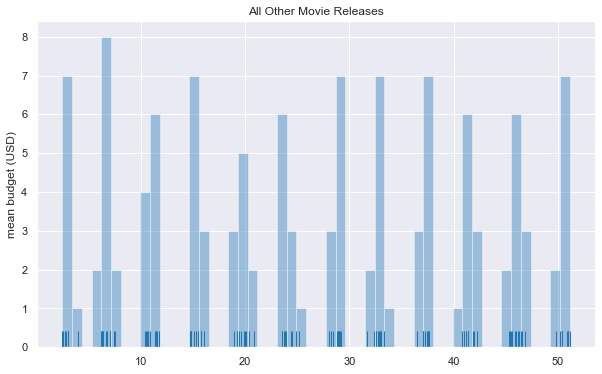

In [473]:
# investigate release date effect
import datetime as dt


def release_date_graph(my_df, lower_quantile=0, upper_quantile=1, yaxis='budget', graph_type='bar'):
    """Get a list of movie data.
    Args:
        my_df (pandas.DataFrame):  dataframe from original TMDB query
        lower_quantile (float): lowest quantile to include
        upper_quantile (float): hightest quantile to include
        yaxis (str): what column goes on yaxis ('budget' or 'revenue')
        graph_type (str): 'bar' or 'dist' or 'both'
    Returns:
       df_month (pandas.DataFrame: df used to create plot
       fig (matplotlib.figure.Figure): plt figure for further formatting
       ax (matplotlib.axes._subplots.AxesSubplot): plot axes for further formatting

    """
    # returns a df that has revenue by month info for plotting
    # sortby choices: revenue, budget
    df_month = my_df.loc[:, ['release_date', 'revenue', 'budget']]
    df_month['release_month'] = pd.DatetimeIndex(df_month['release_date']).month
    df_month['release_year'] = pd.DatetimeIndex(df_month['release_date']).year
    df_month['release_week'] = pd.DatetimeIndex(df_month['release_date']).map(lambda x: x.isocalendar()[1])

    #print(df_month.head())

    # blockbuster will be 95th quantile
    low_gate = df_month[yaxis].quantile(lower_quantile)
    high_gate = df_month[yaxis].quantile(upper_quantile)
    print(low_gate, high_gate)
    df_month = df_month[(df_month[yaxis] < high_gate) & (df_month[yaxis] > low_gate)] 
    df_month = df_month.groupby(['release_year', 'release_month']).mean().reset_index()
    
    if graph_type == 'bar':
        fig, ax = make_barplot(df_month, lower_quantile, upper_quantile, yaxis=yaxis)
    elif graph_type == 'dist':
        fig, ax = make_distplot(df_month, lower_quantile, upper_quantile, yaxis=yaxis)

    return df_month, fig, ax


def make_barplot(df_month, lower_quantile, upper_quantile, yaxis='budget'):
    # if user selected bar
    fig = plt.figure(figsize=(10,6))
    ax = sns.barplot(data=df_month, x='release_month', y='revenue', palette='spring') 
    ax.set_title("Mean Revenue by Release Month (quantile {} to {})".format(lower_quantile, upper_quantile))
    xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticklabels(xlabels)
    ax.set(ylabel='mean {} (USD)'.format(yaxis))
    ax.set(xlabel="")
    return fig, ax

def make_distplot(df_month, lower_quantile, upper_quantile, yaxis='budget'):
    # if user selected dist
    fig = plt.figure(figsize=(10,6))
    ax = sns.distplot(df_month['release_week'], rug=True, bins=52, kde=False)
    ax.set_title("Release Distribution (quantile {} to {})".format(lower_quantile, upper_quantile))
    ax.set(ylabel='mean {} (USD)'.format(yaxis))
    ax.set(xlabel="")
    return fig, ax

# quantiles allow us to investigate success of low or high budget movie by release date.
# we can also change the yaxis to look at either revenue or budget.  
# client may want to see when big budget movies are released, but also what months contain the highest revenue movies


df_month2, fig2, ax2 = release_date_graph(df10, lower_quantile=0.9, upper_quantile=1, yaxis='budget', graph_type='bar')  # can send in df5 or df10 for last 5 or 10 years of data
df_month1, fig1, ax1 = release_date_graph(df10, lower_quantile=0, upper_quantile=0.9, yaxis='budget', graph_type='dist')  # can send in df5 or df10 for last 5 or 10 years of data



ax1.set_title("All Other Movie Releases")
ax2.set_title("Blockbuster Releases Only")
print(df_month1['release_week'])

We plotted the average revenues for movies based on the month of their release.  The April release being one of the highest months seemed counterintuitive.  After looking at the highest grossing films, it appears that two Avengers movies as well as several other big revenue generating movies were released in April over the timeframe of our study.  Those outliers added the larger than expected revenue and error bar for April.  

The convention in Hollywood is that big films are released in May/June/July for the summer break, or in Nov/Dec for the holidays.  It appears that some studios are choosing to release their biggest films outside that norm by placing their release dates earliier in the season (Apr and Oct).  

A second graph shows movies that are not blockbusters.  This graph is closer to traditional expectiations. 

# Distribution of all release dates


